# Predicting House Prices#
## Regression Project ##


## Table of contents
* [Introduction: Problem](#introduction)
* [Data](#data)
* [Exploratory Data Analysis](#analysis)
* [Regression Modelling](#modelling)
* [Results and Conclusion](#results)

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

from scipy.stats import boxcox
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
from scipy.special import inv_boxcox

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# Introduction: Problem<a name="introduction"></a>

## House Prices: Advanced Regression Techniques
The dataset for this project was acquired from Kaggle and it describes the sale of individual residential property in Ames, Iowa 

In this project, we'll predict house prices by training a <b>regression</b> model

We'll select features from the dataset which have a high correlation with the <b>Sale Price</b>, our target variable. 



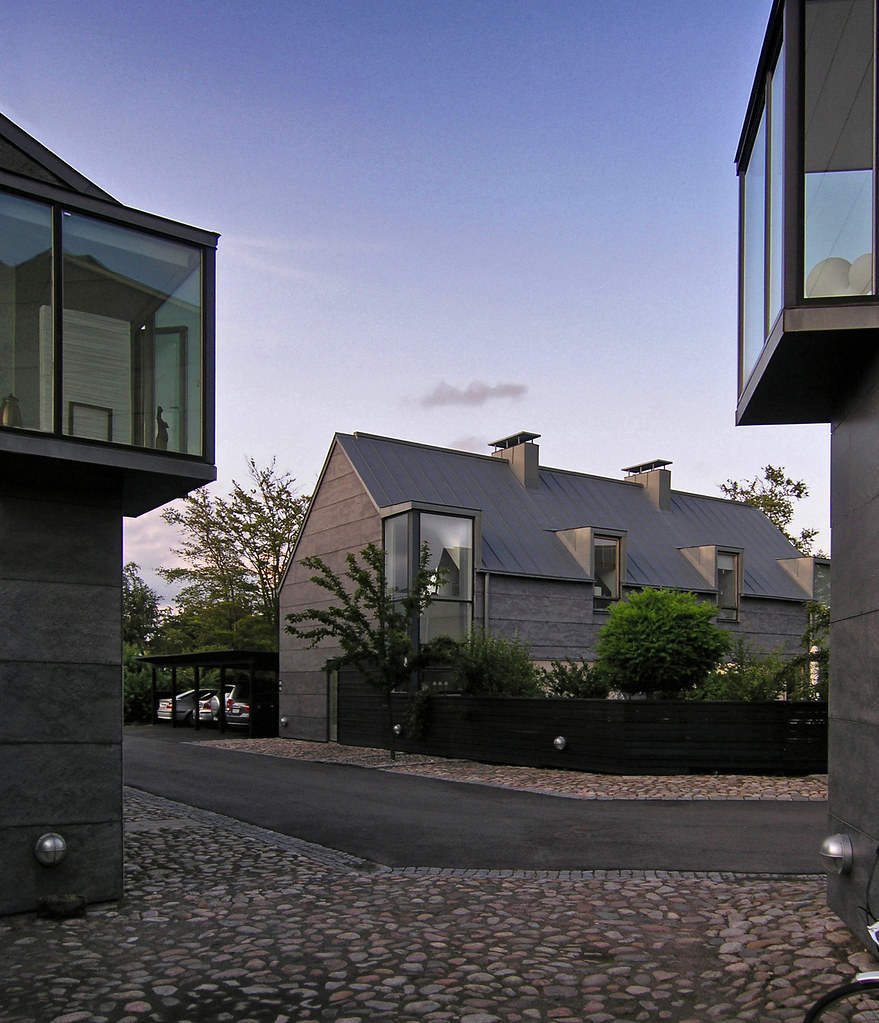

In [2]:
Image("Housing Prices.jpg")

"tegnestuen vandkunsten, architects: tre gudor housing, viken 2000" by seier+seier is licensed under CC BY-NC 2.0

# Data<a name="data"></a>

#### Load the Data, Examine and Explore

In [3]:
## Load in the Ames Housing Data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

#### Let's analyse the features of this dataset

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# This is recommended by the data set author to remove a few outliers
data = df_train.copy() # Keep a copy our original data 
# df_test = df_test.loc[df_test['GrLivArea'] <= 4000,:]
df_train = df_train.loc[df_train['GrLivArea'] <= 4000,:]
print("Number of rows in the data:", df_train.shape[0])
print("Number of columns in the data:", df_train.shape[1])

Number of rows in the data: 1456
Number of columns in the data: 81


#### We have 79 features that describe features of the house### 



### Normalizing Target Variable
Let's inspect the <b>Sale Price</b>, the target variable

In [6]:
SP = df_train['SalePrice']
SP.describe()

count      1456.000000
mean     180151.233516
std       76696.592530
min       34900.000000
25%      129900.000000
50%      163000.000000
75%      214000.000000
max      625000.000000
Name: SalePrice, dtype: float64

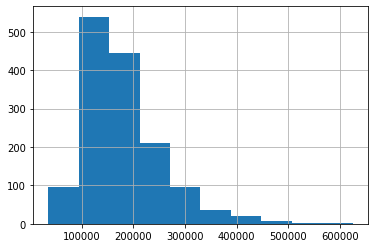

In [7]:
SP.hist()

In [8]:
SP_sample = SP.sample(n=50,random_state = 1)
normaltest(SP_sample)

NormaltestResult(statistic=48.77156502307902, pvalue=2.566783378742388e-11)

Making our target variable normally distributed often will lead to better results

Sale Price is not normally distributed, we will apply a transformation to it and then fit our regression to predict the transformed values

It's not necessary for the Linear Regression algorithm to have a y variable that is normally distributed; however, it is necessary for the errors to be normally distributed and one way to ensure this is by transforming the y variable

We'll use <b>histograms</b> and the <b>D'Agostino K^2 Test</b> to determine normality




There are three transformations that we can apply:
<b></b>
<li>Square root
<li>Log
<li>Box cox

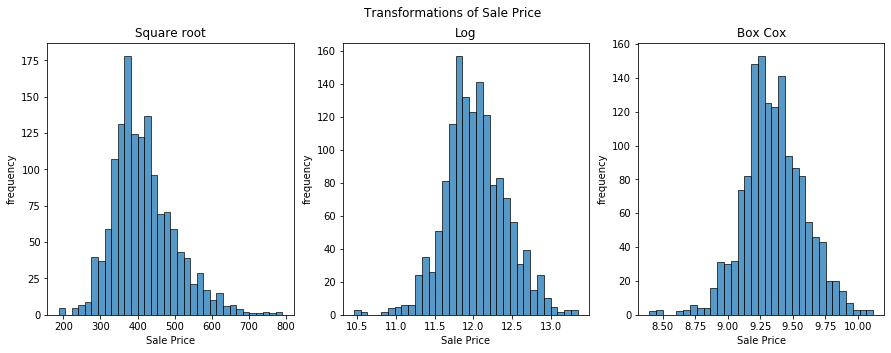

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
# Applying transforms
SP_sq = np.sqrt(SP)
SP_log = np.log(SP)
SP_Bxc_result = boxcox(SP)
SP_Bxc = SP_Bxc_result[0]
SP_Bxc_lam = SP_Bxc_result[1]

# Displaying Histograms alongisde statistical score
# SP_sq.hist(ax = ax1)
# SP_log.hist(ax = ax2)
# SP_Bxc.hist(ax = ax3)

sns.histplot(data = SP_sq, ax = ax1)
sns.histplot(data = SP_log, ax = ax2)
sns.histplot(data = SP_Bxc, ax = ax3)

# formatting of titles
ax1.set(title='Square root', ylabel='frequency', xlabel='Sale Price')
ax2.set(title='Log', ylabel='frequency', xlabel='Sale Price')
ax3.set(title='Box Cox', ylabel='frequency', xlabel='Sale Price')
fig.suptitle('Transformations of Sale Price');

Computing D'Agostino K^2 test results

#### Interpreting the D'Agostino K^2 score
This test outputs a "p-value". The larges the p-value, the closer the distribution is to normal.

We will take a <b>small sample</b> of each distribution as the test detects even minor deviations in very large samples.


In [10]:
SP_sq_sample = np.random.choice(SP_sq, 50)
SP_log_sample = np.random.choice(SP_log, 50)
SP_Bxc_sample = np.random.choice(SP_Bxc, 50)

normaltest_sq = normaltest(SP_sq_sample)[1]
normaltest_log = normaltest(SP_log_sample)[1]
normaltest_Bxc = normaltest(SP_Bxc_sample)[1]

In [11]:
column = {'Transformation' :['Square Root','Log','Box Cox'],
         'D\'Agostino K^2 Score (p-value)': [normaltest_sq,normaltest_log,normaltest_Bxc]}
normal_scores_df = pd.DataFrame(column)
normal_scores_df.set_index('Transformation')

,D'Agostino K^2 Score (p-value)
Transformation,
Square Root,0.040543
Log,0.652924
Box Cox,0.648405


According to frequentist statistics we can the distribution to be normal (more specifically: fail to reject the null hypothesis that it is normal) if p > 0.05.


According to our scores, the p values of Log and Box Cox Transformations are <b>above 0.05</b> and since the p value of Box Cox is higher than Log we'll apply the Box Cox transformation to our target variable

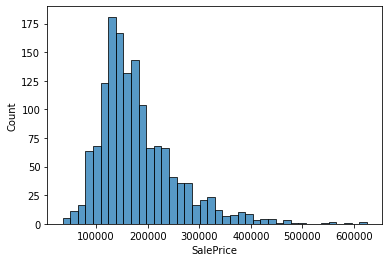

In [12]:
sns.histplot(data = df_train['SalePrice'])

### Handling Missing Data

We'll extract columns that have missing values

In [13]:
missing_percent = []
missing_percent_cols = []
for col_count,col in zip(df_train.count(),df_train.columns):
    percent = ((1456-col_count)/1456) * 100
    if percent != 0:
        missing_percent.append(percent)
        missing_percent_cols.append(col)
columns = {"Column":missing_percent_cols, "% Of Missing Value": missing_percent}
missing_df = pd.DataFrame(columns)
missing_df

,Column,% Of Missing Value
0,LotFrontage,17.788462
1,Alley,93.750000
2,MasVnrType,0.549451
3,MasVnrArea,0.549451
4,BsmtQual,2.541209
5,BsmtCond,2.541209
6,BsmtExposure,2.609890
7,BsmtFinType1,2.541209
8,BsmtFinType2,2.609890
9,Electrical,0.068681


In [14]:
missing_percent_test = []
missing_percent_cols_test = []
for col_count,col in zip(df_test.count(),df_test.columns):
    percent = ((1459-col_count)/1459) * 100
    if percent != 0:
        missing_percent_test.append(percent)
        missing_percent_cols_test.append(col)
columns = {"Column":missing_percent_cols_test, "% Of Missing Value": missing_percent_test}
missing_df_test = pd.DataFrame(columns)
missing_df_test

,Column,% Of Missing Value
0,MSZoning,0.274160
1,LotFrontage,15.558602
2,Alley,92.666210
3,Utilities,0.137080
4,Exterior1st,0.068540
5,Exterior2nd,0.068540
6,MasVnrType,1.096642
7,MasVnrArea,1.028101
8,BsmtQual,3.015764
9,BsmtCond,3.084304


Let's remove columns with more than 75% of missing values

In [15]:
missing_df[missing_df['% Of Missing Value'] > 75]

missing_cols_75 = missing_df[missing_df['% Of Missing Value'] > 75]
missing_cols_75_cols = missing_cols_75['Column'].tolist()

missing_cols_75

,Column,% Of Missing Value
1,Alley,93.750000
16,PoolQC,99.656593
17,Fence,80.769231
18,MiscFeature,96.291209


In [16]:
missing_cols_75 = missing_df[missing_df['% Of Missing Value'] > 75]
missing_cols_75_cols = missing_cols_75['Column'].tolist()

df_train.drop(missing_cols_75_cols, axis = 1, inplace = True)
df_test.drop(missing_cols_75_cols, axis = 1, inplace = True)

### Let's Impute Missing Values

In [17]:
df_train['LotFrontage'].describe()

count    1197.000000
mean       69.693400
std        23.054474
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [18]:
df_train.loc[df_train['LotFrontage'].isna(),'LotFrontage'] = df_train['LotFrontage'].mean()

In [19]:
df_train.loc[df_train['MasVnrType'].isna(),'MasVnrType'] = df_train['MasVnrType'].mode()[0]
df_test.loc[df_test['MasVnrType'].isna(),'MasVnrType'] = df_train['MasVnrType'].mode()[0]

In [20]:
df_train['MasVnrArea'].describe()

count    1448.000000
mean      102.087707
std       177.338930
min         0.000000
25%         0.000000
50%         0.000000
75%       164.250000
max      1600.000000
Name: MasVnrArea, dtype: float64

'MasVnrArea' has a large standard deviation; it's advisable to impute the missing values with the median

In [21]:
df_train.loc[df_train['MasVnrArea'].isna(),'MasVnrArea'] = df_train['MasVnrArea'].median()

In [22]:
df_train.loc[df_train['BsmtQual'].isna(),'BsmtQual']
df_train['BsmtQual'].value_counts()

TA    649
Gd    618
Ex    117
Fa     35
Name: BsmtQual, dtype: int64

In [23]:
df_train['Electrical'].value_counts()

SBrkr    1330
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [24]:
df_train.loc[df_train['Electrical'].isna(), 'Electrical'] = df_train['Electrical'].mode()[0]

In [25]:
df_train['FireplaceQu'].value_counts()

Gd    378
TA    312
Fa     33
Ex     23
Po     20
Name: FireplaceQu, dtype: int64

In [26]:
df_train['Fireplaces'].value_counts()

0    690
1    649
2    113
3      4
Name: Fireplaces, dtype: int64

No meaningful extrapolation can be made from other columns to fill up the 'FireplaceQu' column.
Nearly 50% of categorical data is missing


In [27]:
df_train.drop('FireplaceQu', axis = 1, inplace = True)
df_test.drop('FireplaceQu', axis = 1, inplace = True)

Since the standard deviation isn't too large we can impute the missing values with the mean

In [28]:
df_test.loc[df_test['LotFrontage'].isna(),'LotFrontage'] = df_test['LotFrontage'].mean()

In [29]:
df_test.loc[df_test['MasVnrArea'].isna(),'MasVnrArea'] = df_test['MasVnrArea'].median()

In [30]:
# Missing data indicates no cars
for column in ('GarageYrBlt', 'GarageArea', 'GarageCars','GarageType','GarageQual','GarageFinish'):
    df_train[column] = df_train[column].fillna(0)
    df_test[column] = df_test[column].fillna(0)

In [31]:
df_test.loc[df_test['SaleType'].isna(),'SaleType'] = df_train['SaleType'].mode()[0]

In [32]:
# Missing values for basement implies no basement
for column in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df_train[column] = df_train[column].fillna(0)
    df_test[column] = df_test[column].fillna(0)

In [33]:
df_test['KitchenQual'].value_counts()

TA    757
Gd    565
Ex    105
Fa     31
Name: KitchenQual, dtype: int64

In [34]:
df_test.loc[df_test['KitchenQual'].isna(),'KitchenQual'] = df_train['KitchenQual'].mode()[0]

In [35]:
df_train['Functional'].value_counts()

Typ     1356
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [36]:
df_test.loc[df_test['Functional'].isna(),'Functional'] = df_train['Functional'].mode()[0]

In [37]:
df_test.loc[df_test['MSZoning'].isna(),'MSZoning'] = df_train['MSZoning'].mode()[0]

In [38]:
df_test.loc[df_test['Utilities'].isna(),'Utilities'] = df_train['Utilities'].mode()[0]

In [39]:
df_test.loc[df_test['Exterior1st'].isna(),'Exterior1st'] = df_train['Exterior1st'].mode()[0]

In [40]:
df_test.loc[df_test['Exterior2nd'].isna(),'Exterior2nd'] = df_train['Exterior2nd'].mode()[0]

#### All of the missing data has been handled

### Transforming predictor variables for optimal model performance

We'll extract continuous predictor variables that are skewed and apply a log transform to make them more normally distributed

In [41]:
# Collecting float variables
mask = df_train.dtypes == np.float
float_cols = df_train.columns[mask]

# Identifying variables that are skewed
skew_values = df_train[float_cols].skew()

skew_cols = (skew_values
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > 0.7'))

skew_cols

,Skew
LotFrontage,1.694146
MasVnrArea,2.657499
GarageYrBlt,-3.863232


In [42]:
for col in skew_cols.index.tolist():
    if col == "SalePrice":
        continue
    df_train[col] = df_train[col].apply(np.log1p)
    df_test[col]  = df_test[col].apply(np.log1p)

In [43]:
num_predictor_variables = df_train.select_dtypes(include=[np.number])

One hot encoding categorical variables

In [44]:
# removing categorical features
cat_remove = ['Street','Utilities','Condition2','RoofMatl','Heating','PoolArea','MiscVal']
df_train.drop(cat_remove, axis =1, inplace = True)
df_test.drop(cat_remove, axis =1, inplace = True)

In [45]:
X = pd.get_dummies(df_train.drop(['SalePrice'], axis = 1))     
df_test = pd.get_dummies(df_test)      
X, test = X.align(df_test, join='inner', axis=1) 

In [46]:
X.shape

(1456, 245)

In [47]:
test.shape

(1459, 245)

In [48]:
df_train = pd.concat([X, df_train['SalePrice']], axis=1)

# Analysis<a name="analysis"></a>

## Exploratory Data Analysis

Let's explore our dataset for patterns and relationships between the target and predictor

In [49]:
corr = num_predictor_variables.corr()
print (corr['SalePrice'].sort_values(ascending=False))

SalePrice        1.000000
OverallQual      0.800858
GrLivArea        0.720516
GarageCars       0.649256
TotalBsmtSF      0.646584
GarageArea       0.636964
1stFlrSF         0.625235
FullBath         0.559048
TotRmsAbvGrd     0.537462
YearBuilt        0.535279
YearRemodAdd     0.521428
Fireplaces       0.466765
MasVnrArea       0.416339
BsmtFinSF1       0.395923
OpenPorchSF      0.330361
LotFrontage      0.328682
WoodDeckSF       0.322538
2ndFlrSF         0.297301
HalfBath         0.282925
LotArea          0.269866
GarageYrBlt      0.246582
BsmtFullBath     0.235697
BsmtUnfSF        0.220678
BedroomAbvGr     0.160542
ScreenPorch      0.118324
MoSold           0.056797
3SsnPorch        0.047414
PoolArea         0.032819
BsmtFinSF2      -0.008900
MiscVal         -0.021097
YrSold          -0.023694
LowQualFinSF    -0.025351
Id              -0.027455
BsmtHalfBath    -0.036792
OverallCond     -0.080202
MSSubClass      -0.088160
EnclosedPorch   -0.129774
KitchenAbvGr    -0.138849
Name: SalePr

Let's select features which have a correlation magnitude <b>greater</b> than 0.6

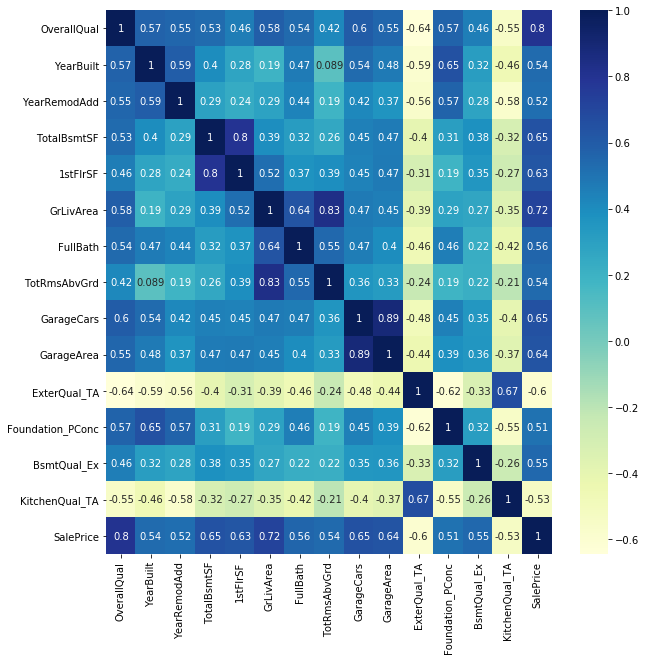

In [50]:
corr_matrix = df_train.corr()
num_predictors = corr_matrix.index[abs(corr_matrix["SalePrice"])>0.50]
num_predictors_to_remove = corr_matrix.index[abs(corr_matrix["SalePrice"])<0.25]
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(df_train[num_predictors].corr(),annot=True,cmap="YlGnBu")

'OverallQual' has the highest correlation with our target followed by Year variables, this makes sense as recently built houses generally have higher prices

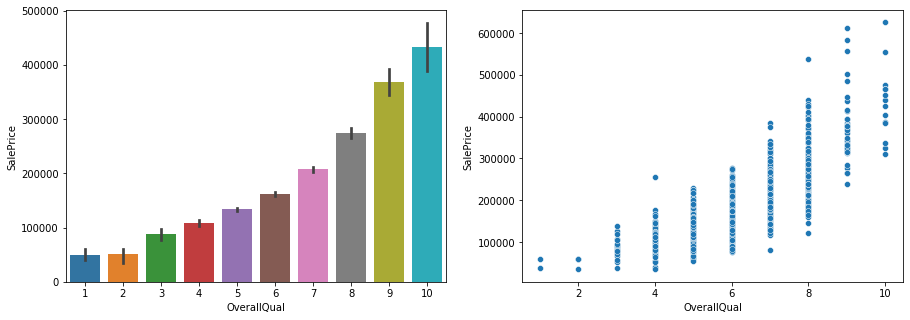

In [51]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
sns.barplot(x = 'OverallQual', y= 'SalePrice',data = df_train, ax = ax1)
sns.scatterplot(x = 'OverallQual', y= 'SalePrice', data = df_train,ax = ax2)

OverallQual seems to have a non linear  relationship, we can square this column to achieve linearity

In [52]:
df_train['OverallQ2'] = df_train['OverallQual'] ** 2
X['OverallQ2'] = df_train['OverallQ2']
test['OverallQ2'] = df_test['OverallQual']**2

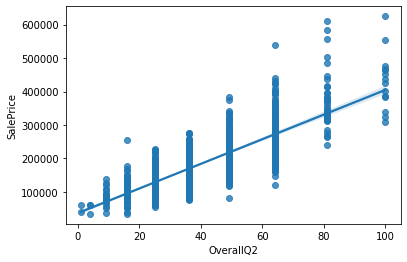

In [53]:
sns.regplot(x = 'OverallQ2', y= 'SalePrice', data = df_train)

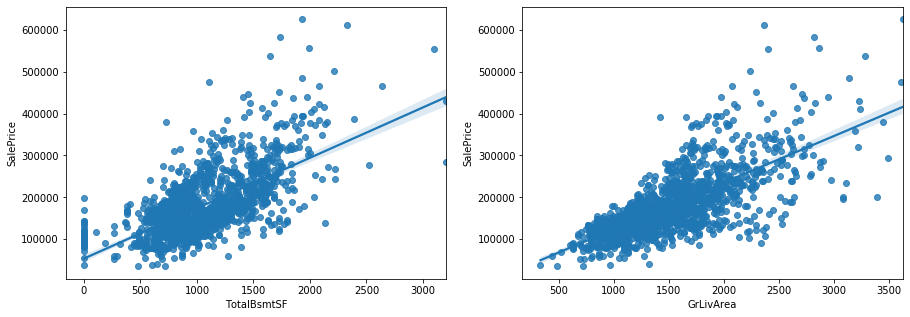

In [54]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
sns.regplot(x = 'TotalBsmtSF', y= 'SalePrice', data = df_train,ax = ax1)
sns.regplot(x = 'GrLivArea', y= 'SalePrice',data = df_train, ax = ax2)

We can combine these two features since they are highly correlated

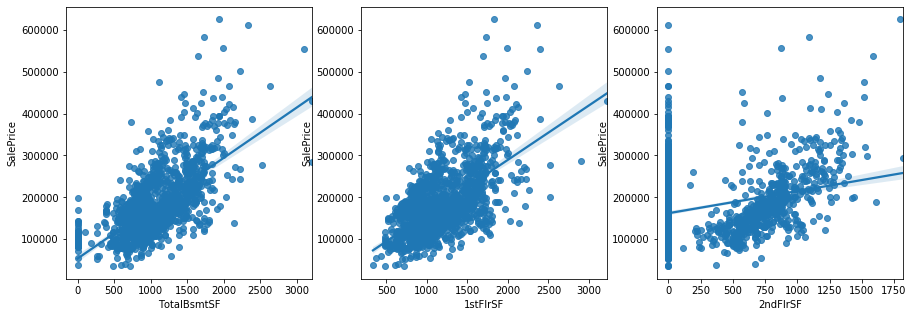

In [55]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))
sns.regplot(x = 'TotalBsmtSF', y= 'SalePrice', data = df_train,ax = ax1)
sns.regplot(x = '1stFlrSF', y= 'SalePrice',data = df_train, ax = ax2)
sns.regplot(x = '2ndFlrSF', y= 'SalePrice',data = df_train, ax = ax3)

We can combine these 3 features to form a new feature since they are correlated

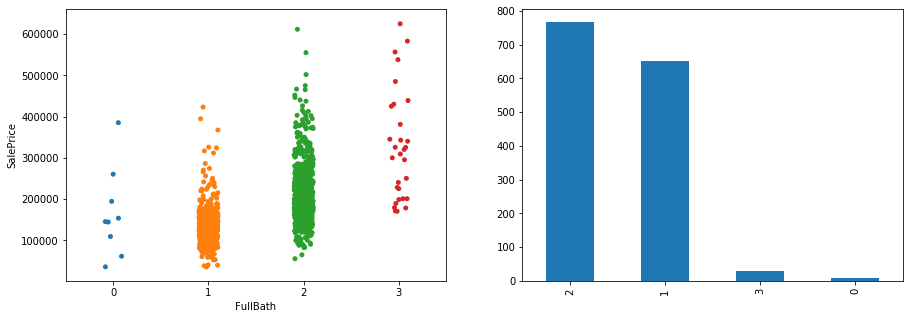

In [56]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,5))
sns.stripplot(x = 'FullBath', y= 'SalePrice', data = df_train, ax = ax1)
df_train['FullBath'].value_counts().plot(kind = 'bar',ax = ax2)

The price increases with the number of bathrooms; however, most houses seem to have 2 bathrooms and only the most expensive have 3 bathrooms

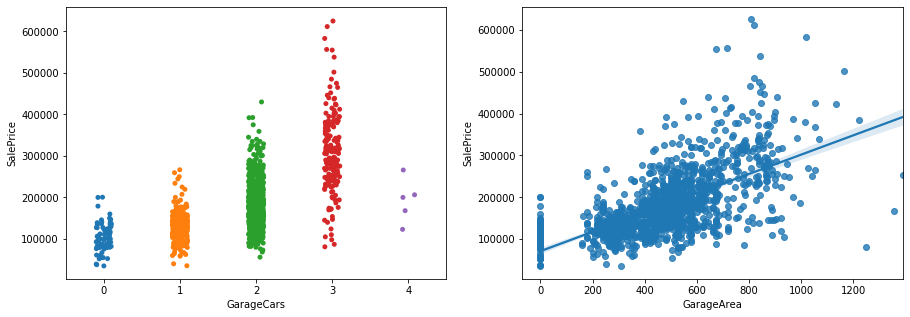

In [57]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
sns.stripplot(x = 'GarageCars', y= 'SalePrice', data = df_train,ax = ax1)
sns.regplot(x = 'GarageArea', y= 'SalePrice',data = df_train, ax = ax2)

Notice that the Sale Price drops once we have more than 3 Garage Cars

## Feature Engineering

We'll select features from our dataset to train our model

### Creating new features

There's clearly a premium on houses which were built more recently and have a higher overall quality 

In [58]:
X['OvQlt*YrBlt'] = df_train['OverallQual'] * df_train['YearBuilt']
test['OvQlt*YrBlt'] = df_test['OverallQual'] * df_test['YearBuilt']

We can divide the overall quality by the lot area to get a term which represents the overall quality per sqft

In [59]:
X['OvQlt/LotA'] = df_train['OverallQual'] / df_train['LotArea']
test['OvQlt/LotA'] = df_test['OverallQual'] / df_test['LotArea']

X.drop(['OverallQual'], axis = 1, inplace = True)
test.drop(['OverallQual'], axis = 1, inplace = True)

A term to represent the Total Square Footage of a house

In [60]:
X['Total_Sq'] = df_train['TotalBsmtSF'] + df_train['GrLivArea']
test['Total_Sq'] = df_test['TotalBsmtSF'] + df_test['GrLivArea']

Before proceeding, let's remove variables which have no/spurious impact on the target

In [61]:
X.drop(num_predictors_to_remove, axis = 1, inplace = True)
test.drop(num_predictors_to_remove, axis = 1, inplace = True)

# Modelling <a name="modelling"></a>

In [62]:
# Let's split our training set
df_train['SalePrice'] = SP_Bxc #Box Cox Transformation of Target variable to make it more normally distributed
y = df_train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

<b> Regularization a.k.a desensitization is very useful in analysing datasets which have a lot of variables</b> <br>
    We will model our raw data using Linear, Ridge, and Lasso Regression using a pipeline

Finding the optimal value for hyperparameter alpha

In [63]:
# RidgeCV automatically returns the optimal alpha hyperparameter
from sklearn.linear_model import RidgeCV

alphas1 = np.geomspace(1, 20, 30)

ridgeCV = RidgeCV(alphas=alphas1, 
                  cv=5).fit(X_train, y_train)

ridgeCV_r2 = r2_score(y_test, ridgeCV.predict(X_test))

print(ridgeCV.alpha_, ridgeCV_r2)

20.000000000000004 0.8779525774378605


In [64]:
from sklearn.linear_model import LassoCV

alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])

lassoCV = LassoCV(alphas=alphas2,
                  max_iter=5e4,
                  tol = 0.06,
                  cv=3).fit(X_train, y_train)

lassoCV_r2 = r2_score(y_test, lassoCV.predict(X_test))

print(lassoCV.alpha_, lassoCV_r2) 

1e-05 0.8689005297975678


Ridge performs slightly better as it doesn't cancel elements out by labelling their coefficients to 0(like Lasso)

In [70]:
train_predictions = ridgeCV.predict(X)

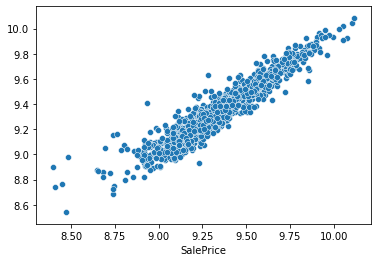

In [73]:
sns.scatterplot(x=y,y=train_predictions)

In [65]:
predictions = ridgeCV.predict(test)

In [66]:
r2_score(y_test, ridgeCV.predict(X_test))

0.8779525774378605

# Results <a name="results"></a>

Applying inverse BoxCox transform

In [67]:
predictions_final = inv_boxcox(predictions,SP_Bxc_lam)

In [68]:
columns = {'Id' : df_test['Id'], 'SalePrice' : predictions_final}
submission_dataframe = pd.DataFrame(columns)
submission_dataframe.set_index('Id')
submission_dataframe

,Id,SalePrice
0,1461,116496.179252
1,1462,158303.960360
2,1463,178401.775552
3,1464,195006.936794
4,1465,185144.451046
...,...,...
1454,2915,82372.666689
1455,2916,91061.764381
1456,2917,172363.553664
1457,2918,113374.665833


In [69]:
submission_dataframe.to_csv('submission.csv' , index = False)

Root Mean Logarithmic Score of Submission = 0.13286